In [1]:
import csv
import numpy as np
import snntorch as snn
import torch
from snntorch import spikegen
from snntorch import utils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from snntorch import spikeplot as splt
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import itertools

from snntorch import surrogate
import seaborn as sns

from sklearn.metrics import confusion_matrix

file = open("Arthymia_4_para.csv")

num_steps = 10
batch_size = 100
num_epochs = 100
loss_hist = []
test_loss_hist = []
counter = 0
num_inputs = 1*4
num_hidden = 8
num_outputs = 7
beta = 0.575
learning_rate = 6.8e-4
torch.manual_seed(501) # 501
dtype = torch.float


In [2]:
numpy_array = np.genfromtxt("Arthymia_4_para.csv", delimiter=",", dtype=None, names=True, encoding=None)

In [4]:
numpy_array

array([( 672,  88, 178, 420, 'NORMAL SINUS RHYTHM'),
       ( 648, 101, 178, 389, 'NORMAL SINUS RHYTHM'),
       ( 685,  98, 159, 428, 'NORMAL SINUS RHYTHM'), ...,
       (1324, 150, 300, 475, 'WIDE BRADYCARDIA'),
       (1320, 137, 343, 434, 'WIDE BRADYCARDIA'),
       ( 600,  80, 160, 400, 'NORMAL SINUS RHYTHM')],
      dtype=[('628', '<i4'), ('114', '<i4'), ('164', '<i4'), ('393', '<i4'), ('NORMAL_SINUS_RHYTHM', '<U19')])

In [3]:
in_data = np.array([(x[0], x[1], x[2], x[3]) for x in numpy_array])
out_data = np.array([(x[4]) for x in numpy_array])

class_enum = {'NORMAL SINUS RHYTHM': 0,
 'SINUS BRADYCARDIA': 1,
 'WIDE BRADYCARDIA': 2,
 'SINUS TACHYCARDIA': 3,
 'WIDE TACHYCARDIA': 4,
 'NARROW BRADYCARDIA': 5,
 'NARROW TACHYCARDIA': 6}

output_data = [class_enum[x] for x in out_data]

inputs_tensor = torch.tensor(in_data, dtype=torch.float32)
outputs_tensor = torch.tensor(output_data, dtype=torch.long)

dataset = TensorDataset(inputs_tensor, outputs_tensor)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
outputs_tensor

tensor([0, 0, 0,  ..., 2, 2, 0])

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            # print(spk1)
            # print(spk2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

In [6]:

test_accuracy_data = []
train_accuracy_data = []

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        train_accuracy_data.append(acc*100)
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")
        test_accuracy_data.append(acc*100)

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [7]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [8]:
data, targets = next(iter(data_loader))
data = data.to(device)
targets = targets.to(device)

In [9]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([10, 100, 7])


In [10]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 23.872
Train set accuracy for a single minibatch: 9.00%


In [11]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [12]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 23.728
Train set accuracy for a single minibatch: 9.00%


In [13]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(data_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        # print(data.shape)
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(data_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 5 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 24.36
Test Set Loss: 24.99
Train set accuracy for a single minibatch: 8.00%
Test set accuracy for a single minibatch: 6.00%


Epoch 0, Iteration 5
Train Set Loss: 25.10
Test Set Loss: 23.67
Train set accuracy for a single minibatch: 6.00%
Test set accuracy for a single minibatch: 9.00%


Epoch 0, Iteration 10
Train Set Loss: 24.56
Test Set Loss: 25.26
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 3.00%


Epoch 0, Iteration 15
Train Set Loss: 22.86
Test Set Loss: 22.66
Train set accuracy for a single minibatch: 10.00%
Test set accuracy for a single minibatch: 8.00%


Epoch 0, Iteration 20
Train Set Loss: 24.25
Test Set Loss: 22.59
Train set accuracy for a single minibatch: 7.00%
Test set accuracy for a single minibatch: 12.00%


Epoch 0, Iteration 25
Train Set Loss: 23.72
Test Set Loss: 23.25
Train set accuracy for a single minibatch: 6.00%
Test set accuracy for a single minibatch: 7.00%


Epoch 0, Iterati

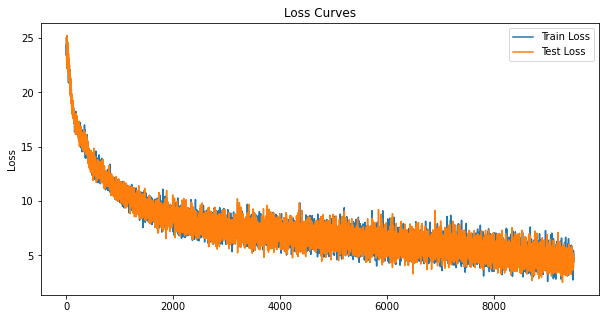

In [14]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.ylabel("Loss")
plt.show()

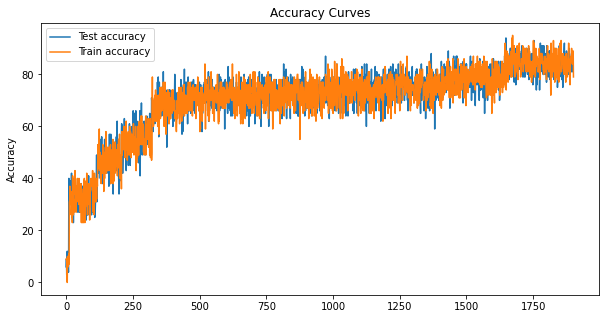

In [15]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(test_accuracy_data)
plt.plot(train_accuracy_data)
plt.title("Accuracy Curves")
plt.legend(["Test accuracy", "Train accuracy"])
plt.ylabel("Accuracy")
plt.show()

In [16]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set : {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set : 8056/9500
Test Set Accuracy: 84.80%


In [17]:
targets

tensor([6, 1, 0, 1, 6, 2, 0, 0, 4, 3, 0, 0, 2, 0, 6, 5, 0, 0, 3, 0, 0, 0, 0, 1,
        5, 4, 2, 1, 2, 0, 4, 6, 0, 3, 0, 0, 3, 0, 0, 4, 5, 3, 2, 0, 4, 3, 6, 6,
        2, 0, 3, 4, 3, 1, 4, 6, 2, 2, 2, 0, 3, 3, 6, 0, 0, 4, 4, 1, 6, 4, 6, 6,
        3, 1, 1, 4, 1, 1, 0, 2, 1, 2, 3, 6, 6, 2, 2, 5, 4, 4, 0, 0, 2, 2, 3, 0,
        3, 2, 2, 4])

In [18]:
predicted

tensor([6, 2, 0, 5, 6, 2, 0, 0, 4, 3, 0, 0, 2, 0, 6, 5, 0, 6, 3, 0, 0, 0, 0, 5,
        5, 4, 0, 5, 2, 0, 4, 6, 0, 0, 5, 0, 3, 0, 0, 4, 5, 3, 2, 3, 4, 3, 6, 6,
        2, 0, 3, 4, 3, 5, 4, 0, 2, 2, 2, 0, 3, 3, 6, 0, 0, 4, 4, 2, 6, 4, 6, 6,
        3, 2, 2, 4, 5, 5, 0, 2, 5, 2, 0, 0, 6, 2, 2, 5, 4, 4, 0, 0, 2, 2, 3, 0,
        0, 2, 2, 4])

In [19]:
conf_matrix = confusion_matrix(targets, predicted)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[24  0  0  1  0  1  1]
 [ 0  0  4  0  0  7  0]
 [ 1  0 16  0  0  0  0]
 [ 3  0  0 11  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  4  0]
 [ 2  0  0  0  0  0 11]]


In [20]:
conf_matrix[1][1]=conf_matrix[1][2]
conf_matrix[1][2]=0

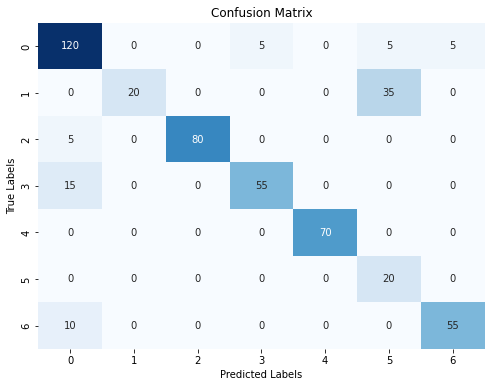

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [22]:
# Calculating specificity for each class
num_classes = len(conf_matrix)
specificity = np.zeros(num_classes)

for i in range(num_classes):
    # True negatives for the current class
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    
    # False positives for other classes
    fp = np.sum(np.delete(conf_matrix[i, :], i))
    
    # Specificity for the current class
    specificity[i] = tn / (tn + fp)

print("Confusion Matrix:")
print(conf_matrix)
print(specificity)

Confusion Matrix:
[[24  0  0  1  0  1  1]
 [ 0  4  0  0  0  7  0]
 [ 1  0 16  0  0  0  0]
 [ 3  0  0 11  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  4  0]
 [ 2  0  0  0  0  0 11]]
[0.95714286 0.92708333 0.98809524 0.96590909 1.         1.
 0.97727273]


In [23]:
# 81.11
# num_steps = 10
# batch_size = 100
# num_epochs = 100
# loss_hist = []
# test_loss_hist = []
# counter = 0
# num_inputs = 1*2
# num_hidden = 8
# num_outputs = 7
# beta = 0.59
# learning_rate = 6.8e-4
# torch.manual_seed(500)

In [24]:
# 84.80
# num_steps = 10
# batch_size = 100
# num_epochs = 100
# loss_hist = []
# test_loss_hist = []
# counter = 0
# num_inputs = 1*4
# num_hidden = 8
# num_outputs = 7
# beta = 0.575
# learning_rate = 6.8e-4
# torch.manual_seed(501)